In [1]:
# instalando o pyspark
!pip install pyspark

# verifica se foi instalado
from pyspark.sql import SparkSession
spark = SparkSession.builder.master('local[*]').getOrCreate()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=9612f1e52b1b6134fa6792faef6fdc8e3e8c64effd53907182968de3c3f45532
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [2]:
!git clone https://github.com/apache/spark.git /content/spark

# Conexão com Google Drive

from google.colab import drive
drive.mount('/content/drive')

Cloning into '/content/spark'...
remote: Enumerating objects: 1115932, done.
remote: Counting objects: 100% (2005/2005), done.
remote: Compressing objects: 100% (1141/1141), done.
remote: Total 1115932 (delta 786), reused 1410 (delta 433), pack-reused 1113927
Receiving objects: 100% (1115932/1115932), 418.26 MiB | 14.99 MiB/s, done.
Resolving deltas: 100% (539914/539914), done.
Updating files: 100% (22452/22452), done.
Mounted at /content/drive


In [3]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql import DataFrame as SparkDataFrame
from pyspark.sql import Row


 # carregar dados do Desafio
file_medicos = "/content/drive/My Drive/MBA Machine Learning/DesafioFinal/dados_medicos.xlsx";


spark = SparkSession\
          .builder\
          .appName("DesafioFinal")\
          .master("local[*]")\
          .getOrCreate()


# lendo em pandas
df_medicos_pandas = pd.read_excel(file_medicos)
# convertendo o pandas para dataframe do spark_sql
df_medicos_spark = spark.createDataFrame(df_medicos_pandas)
# criando a tabela temp
df_medicos_spark.createOrReplaceTempView("df_medicos")




In [18]:
# Carregar o arquivos de pacientes via RDD e depois transformar em dataframe.
# Em tese isso não é necessário, mas por algum motivo os arquivos não foram interpretados direito pelo spark.
# Essa foi uma alternativa para contornar o problema.
file_pacientes = "/content/drive/My Drive/MBA Machine Learning/DesafioFinal/dados_pacientes.csv";

# lendo e criando a tabela temp de pacientes
rdd_pacientes = spark.sparkContext.textFile(file_pacientes)
# Separe o RDD em cabeçalho e corpo
header = rdd_pacientes.first()
rdd_body = rdd_pacientes.filter(lambda line: line != header)

# Divida cada linha do corpo por ponto e vírgula
rdd_rows = rdd_body.map(lambda line: line.split(";"))

# Crie o DataFrame usando o cabeçalho e o RDD de linhas
df_pacientes = rdd_rows.toDF(header.split(";"))

# criando a tabela temp de pacientes
df_pacientes.createOrReplaceTempView("df_pacientes")

In [5]:
# carregar o arquivos de estados via RDD e depois transformar em dataframe.
# Em tese isso não é necessário, mas por algum motivo os arquivos não foram interpretados direito pelo spark.
# Essa foi uma alternativa para contornar o problema.

file_estados_br = "/content/drive/My Drive/MBA Machine Learning/DesafioFinal/estados_brasileiros.csv";

# lendo e criando a tabela temp de estados
rdd_estados = spark.sparkContext.textFile(file_estados_br)
# Separe o RDD em cabeçalho e corpo
header = rdd_estados.first()
rdd_body = rdd_estados.filter(lambda line: line != header)

# Divida cada linha do corpo por ponto e vírgula
rdd_rows = rdd_body.map(lambda line: line.split(";"))

# Crie o DataFrame usando o cabeçalho e o RDD de linhas
df_estados = rdd_rows.toDF(header.split(";"))

# criando a tabela temp de pacientes
df_estados.createOrReplaceTempView("df_estados")



In [6]:
# testando
qry_medicos = "select * from df_medicos where id_cliente = 2"
qry_pacientes = "select * from df_pacientes"
qry_estados = "select * from df_estados"

r_med = spark.sql(qry_medicos)
r_pac = spark.sql(qry_pacientes)
r_est = spark.sql(qry_estados)


r_pac.show()

+----------+---------+-----+---------+------------+-------+--------------+
|id_cliente|id_estado|idade|   genero|estado Civil|  renda|nivel_educacao|
+----------+---------+-----+---------+------------+-------+--------------+
|         1|       21|   24| Feminino|  Divorciado|8672.21|      Superior|
|         2|       14|   60| Feminino|      Casado|2946.06|      Superior|
|         3|       26|   23| Feminino|    Solteiro|5872.48|         medio|
|         4|       18|   51|Masculino|      Casado|7871.49|      Superior|
|         5|        4|   51|    Outro|       viuvo|6033.31|      Superior|
|         6|        4|   62|Masculino|    Solteiro|8361.42|         medio|
|         7|       21|   53|    Outro|       viuvo|9074.09|      Superior|
|         8|       27|   46|Masculino|       viuvo|9303.18|         medio|
|         9|       12|   26|    Outro|  Divorciado|9222.33|         medio|
|        10|       14|   59| Feminino|  Divorciado| 1009.4|         medio|
|        11|        6|   

In [7]:
# Qual é a idade média das pessoas
# que residem no estado de Minas Gerais?

qry = """

select
  AVG(p.idade) MediaIdade
from df_pacientes p
  join df_estados e on e.id_estado = p.id_estado
where e.id_estado = 13

"""

spark.sql(qry).show()

+----------------+
|      MediaIdade|
+----------------+
|41.1219512195122|
+----------------+



In [8]:
# retornando os dados de renda e genero para visualizar e verificar necessidade de correção dos dados.
qry = """

select
  p.renda, p.genero
from df_pacientes p
  join df_estados e on e.id_estado = p.id_estado
where e.id_estado = 13
and p.renda is not null

"""
spark.sql(qry).show()


# verificando quantidade de generos.
qry = """

select
  p.genero, count(*) Qtd
from df_pacientes p
  join df_estados e on e.id_estado = p.id_estado
where e.id_estado = 13
  and p.renda is not null
group by p.genero

"""
spark.sql(qry).show()


+-------+---------+
|  renda|   genero|
+-------+---------+
|8339.84| Feminino|
|9336.11|Masculino|
|1610.89|Masculino|
|9881.47|    Outro|
|1215.07|Masculino|
|5651.39|Masculino|
|5301.38|    Outro|
|4607.31|    Outro|
| 1990.4| Feminino|
|7388.44|    Outro|
|1481.12| Feminino|
|3703.61| Feminino|
|6154.57| Feminino|
|5626.02|Masculino|
|7882.25|    Outro|
|3799.22|Masculino|
|4006.36| Feminino|
|7150.53|Masculino|
|9081.23|    Outro|
| 4849.9|    Outro|
+-------+---------+
only showing top 20 rows

+---------+---+
|   genero|Qtd|
+---------+---+
| Feminino| 17|
|    Outro| 12|
|Masculino| 12|
+---------+---+



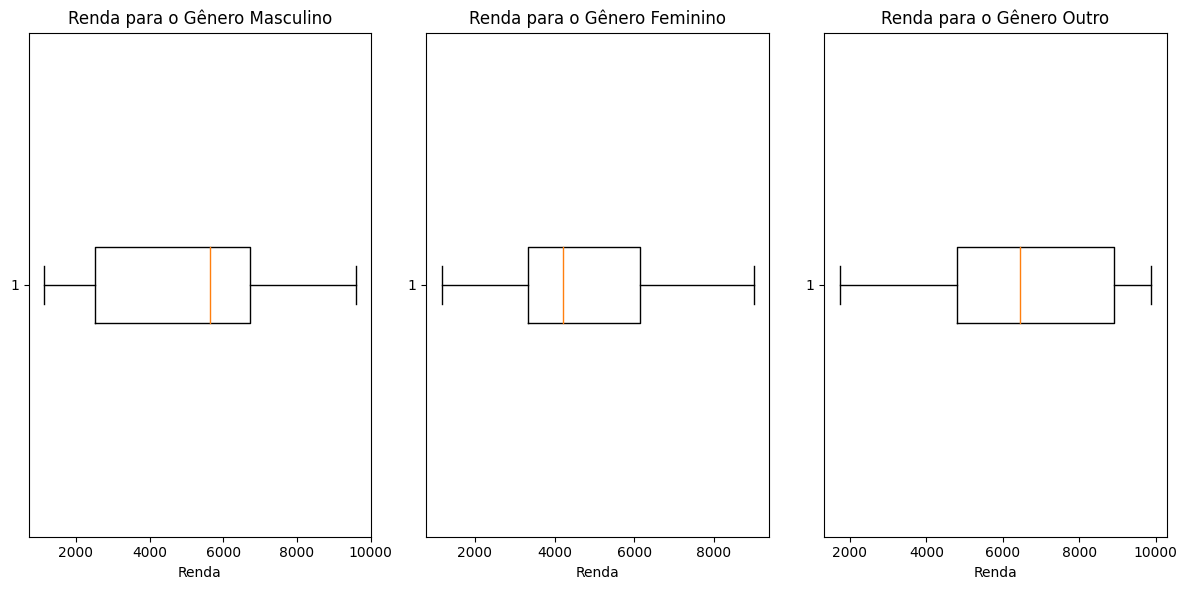

In [9]:
# Crie um gráfico de caixa (boxplot) para representar a distribuição da renda por gênero das pessoas que residem no estado de Minas Gerais e, em seguida, responda:

# Qual é o gênero que possui maior mediana da renda representado no gráfico de caixa?

import matplotlib.pyplot as plt

qry = """

select
  p.renda, p.genero
from df_pacientes p
  join df_estados e on e.id_estado = p.id_estado
where e.id_estado = 13
and p.renda is not null

"""
result = spark.sql(qry)

df_result = result.toPandas()

# Converta os valores da coluna 'renda' para numéricos
df_result['renda'] = pd.to_numeric(df_result['renda'], errors='coerce')

# Remova os valores nulos da coluna 'renda', se houver
df_result.dropna(subset=['renda'], inplace=True)

# Separe os dados por gênero
df_masculino = df_result[df_result['genero'] == 'Masculino']
df_feminino = df_result[df_result['genero'] == 'Feminino']
df_outro = df_result[df_result['genero'] == 'Outro']

# Crie os boxplots separados
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.boxplot(df_masculino['renda'], vert=False)
plt.title('Renda para o Gênero Masculino')
plt.xlabel('Renda')

plt.subplot(1, 3, 2)
plt.boxplot(df_feminino['renda'], vert=False)
plt.title('Renda para o Gênero Feminino')
plt.xlabel('Renda')


plt.subplot(1, 3, 3)
plt.boxplot(df_outro['renda'], vert=False)
plt.title('Renda para o Gênero Outro')
plt.xlabel('Renda')

plt.tight_layout()
plt.show()


<Figure size 1200x600 with 0 Axes>

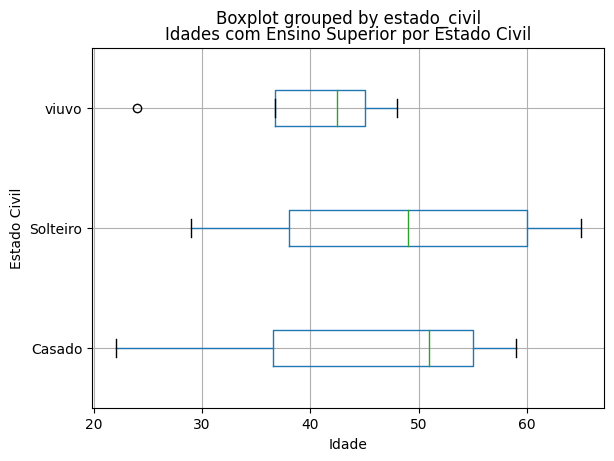

In [32]:
# Crie um gráfico de caixa (boxplot) para representar as idades das pessoas que
# possuem níveis de educação superior, categorizadas por seu estado civil.
# Em seguida, escolha o gráfico que melhor representa essa distribuição.

qry = """

select
  idade, estado_civil
from df_pacientes p
  join df_estados e on e.id_estado = p.id_estado
where
  nivel_educacao = 'Superior'
  and e.id_estado = 13
"""
result = spark.sql(qry)

# Viuvo
# Divorciado
# Solteiro
# Casado

df_result = result.toPandas()

# Converta os valores da coluna 'renda' para numéricos
df_result['idade'] = pd.to_numeric(df_result['idade'], errors='coerce')

plt.figure(figsize=(12, 6))
df_result.boxplot(column="idade", by= "estado_civil", vert=False)
plt.title('Idades com Ensino Superior por Estado Civil')
plt.xlabel('Idade')
plt.ylabel('Estado Civil')
plt.show()

In [50]:
# Calcule estatísticas descritivas para a variável "colesterol" agrupadas por nível de educação.

qry = """

select
  nivel_educacao,
  colesterol
from df_medicos m
  join df_pacientes p on p.id_cliente = m.id_cliente
order by nivel_educacao, colesterol
"""
result = spark.sql(qry)

df_result = result.toPandas()

estatisticas_descritivas = df_result.groupby('nivel_educacao')['colesterol'].agg(['count', 'mean', 'median',  lambda x: x.mode().iloc[0], 'std', 'min', 'max'])
# Renomeie as colunas
estatisticas_descritivas.columns = ['Contagem', 'Média', 'Mediana', 'Moda', 'Desvio Padrão', 'Mínimo', 'Máximo']


print(estatisticas_descritivas)


                Contagem       Média  Mediana  Moda  Desvio Padrão  Mínimo  \
nivel_educacao                                                               
Fundamental          179  173.418994    172.0   163      37.652281     102   
Superior             205  170.360976    169.0   110      39.530039     102   
medio                163  167.245399    167.0   129      40.243716     102   

                Máximo  
nivel_educacao          
Fundamental        235  
Superior           235  
medio              232  


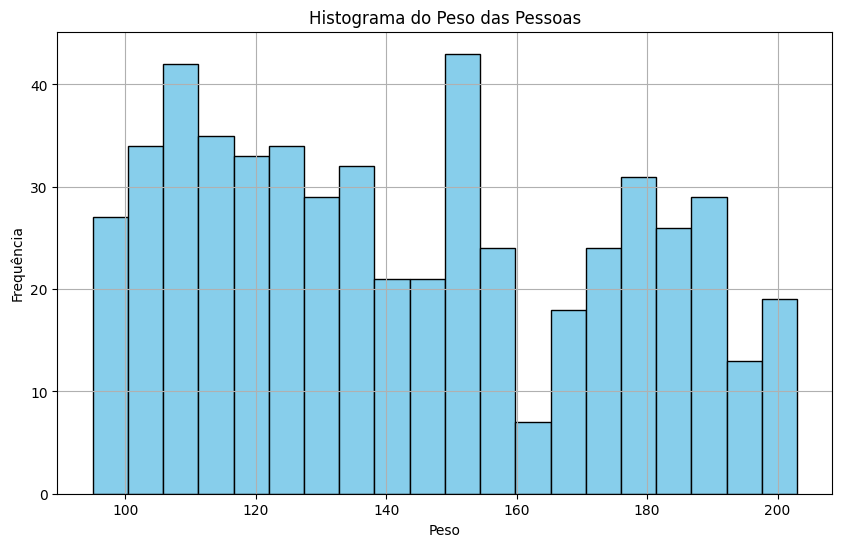

In [57]:
# Crie um histograma com 20 barras representando o peso das pessoas.

qry = """

select
  m.peso
from df_medicos m

"""

result = spark.sql(qry)
result_df = result.toPandas()


# Crie o histograma
plt.figure(figsize=(10, 6))
result_df['peso'].hist(bins=20, color='skyblue', edgecolor='black')
plt.title('Histograma do Peso das Pessoas')
plt.xlabel('Peso')
plt.ylabel('Frequência')
plt.show()


In [103]:
qry = """

WITH RendaPorEstado AS (
select
  p.renda,
  e.sigla_estado,
  p.estado_civil,
  ROW_NUMBER() OVER(PARTITION BY e.sigla_estado ORDER BY p.renda DESC) AS rank_renda
from df_pacientes p
  join df_estados e on e.id_estado = p.id_estado
)

select * from RendaPorEstado r
  join df_estados e on e.sigla_estado = r.sigla_estado
where rank_renda = 1
order by renda desc
limit 1

"""
spark.sql(qry).show()

+-------+------------+------------+----------+---------+------+------------+------+
|  renda|sigla_estado|estado_civil|rank_renda|id_estado|estado|sigla_estado|  pais|
+-------+------------+------------+----------+---------+------+------------+------+
|9998.81|          PR|    Solteiro|         1|       16|Parana|          PR|Brasil|
+-------+------------+------------+----------+---------+------+------------+------+



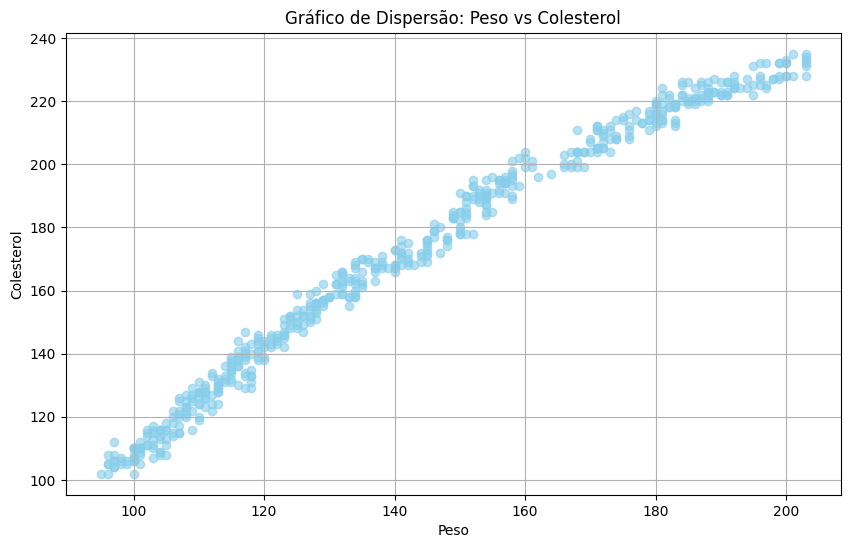

In [112]:
# Crie um gráfico de dispersão que represente as relações entre as variáveis peso (eixo x) e colesterol (eixo y)

qry = """

select peso, colesterol from df_medicos p

"""

result = spark.sql(qry)

# Converta o DataFrame Spark em DataFrame Pandas
df_result = result.toPandas()

# Crie o gráfico de dispersão
plt.figure(figsize=(10, 6))
plt.scatter(df_result['peso'], df_result['colesterol'], color='skyblue', alpha=0.6)
plt.title('Gráfico de Dispersão: Peso vs Colesterol')
plt.xlabel('Peso')
plt.ylabel('Colesterol')
plt.grid(True)
plt.show()

In [123]:
# Ao aplicar um modelo de regressão linear usando machine learning,
# responda à seguinte pergunta: Qual é o valor estimado de colesterol
# para uma pessoa que possui um peso de 128 quilos, com base no modelo?

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

qry = """

select peso, colesterol from df_medicos p

"""

result = spark.sql(qry)

df_result = result.toPandas()

df_result['peso'].fillna(df_result['peso'].median(), inplace=True)

X = df_result['peso'].values.reshape(-1, 1)  # Recurso: Peso
y = df_result['colesterol'].values            # Rótulo: Colesterol

# Divida os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Instancie e treine o modelo de regressão linear
modelo = LinearRegression()
modelo.fit(X_train, y_train)

# Faça a previsão para um peso de 128 quilos
peso = [[128]]
colesterol_estimado = modelo.predict(peso)


# Exiba o valor estimado de colesterol
print("O valor estimado de colesterol para uma pessoa com um peso de 128 quilos é:", colesterol_estimado[0])

# Qual é o valor do coeficiente angular da reta?
coef_angular = modelo.coef_[0]
print("O valor do coeficiente angular da reta é:", coef_angular)

# Qual foi o coeficiente de determinação R² do modelo?
r_squared = modelo.score(X_test, y_test)
print("O coeficiente de determinação R² do modelo é:", r_squared)

# Faça previsões com os dados de teste
y_pred = modelo.predict(X_test)

# Qual o valor do mean absolute error (MAE) do modelo criado?
mae = mean_absolute_error(y_test, y_pred)
print("O valor do mean absolute error (MAE) do modelo é:", mae)

# Qual o valor do mean squared error (MSE) do modelo criado?
mse = mean_squared_error(y_test, y_pred)
print("O valor do mean squared error (MSE) do modelo é:", mse)

O valor estimado de colesterol para uma pessoa com um peso de 128 quilos é: 150.74121459158522
O valor do coeficiente angular da reta é: 1.2667600046454353
O coeficiente de determinação R² do modelo é: 0.9511187109172984
O valor do mean absolute error (MAE) do modelo é: 5.228209888527289
O valor do mean squared error (MSE) do modelo é: 72.8712921273815
